In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from polygon import RESTClient
import datetime as dt
import importlib
import os
os.sys.path.append('./Modules') 
import Modules.factor_analysis_functions as factor_analysis_functions
import Modules.stock_data_functions as stock_data_functions
from matplotlib.dates import MonthLocator, DateFormatter
from typing import List, Optional, Dict, Any, Tuple
import requests 
import time
import json
import seaborn as sns
import math
import importlib
importlib.reload(stock_data_functions)
importlib.reload(factor_analysis_functions)



client = RESTClient('tt2gOLH0fHAmPX70a4QURLFy59PRCZr3')
API_key = 'tt2gOLH0fHAmPX70a4QURLFy59PRCZr3'


import scipy.stats as stats
from fredapi import Fred
fred_api = Fred('e48d0413b1cd0a3b30b58d42225373de')

In [5]:
# Regressors and Stocks 
regressor                   = ['SPY','SMH','QQQ','SRVR']
stock                       = ['NVDA',
 'AVGO',
 'TSM',
 'AMD',
 'MU',
 'QCOM',
 'INTC',
 'ARM',
 'TXN',
 'ADI',
 'MRVL',
 'NXPI',
 'MPWR',
 'ASX',
 'MCHP',
 'ALAB',
 'CRDO',
 'STM',
 'ON',
 'GFS',
 'UMC',
 'RMBS',
 'MTSI',
 'SWKS',
 'TSEM',
 'LSCC',
 'QRVO',
 'SITM',
 'CRUS',
 'SMTC',
 'PI',
 'ALGM',
 'SLAB',
 'SIMO',
 'SYNA',
 'DIOD',
 'POWI']

# R2 Params
runlen                      = 3
delta                       = 0.1
short_lookback              = 20
long_lookback               = 60
sigma_lookback_days         = 5

In [3]:
# Data Pulling
daily_start_date            = (dt.datetime.today() - pd.Timedelta(weeks=104)).strftime('%Y-%m-%d')
dt_updated_reg              = False
dt_updated                  = False

minute_waiting_time         = 30
minute_chunksize            = 200
minute_fetch_in_chunks      = False

daily_start_date            = '2023-11-01'
minute_start_date           = '2023-11-01'
daily_end_date              = '2025-11-04'
minute_end_date             = '2025-11-04'

# Beta Tuning
factor_sets = [
    ['SPY'], ['QQQ'], ['SMH'], ['SRVR'],
    ['SPY', 'SMH'], ['QQQ', 'SMH'],
    ['QQQ', 'SRVR'], ['SPY', 'SRVR'],
]


ridge_grid  = [1e-8, 1e-6, 1e-4, 1e-3]
lambdas     = [0.90, 0.94, 0.96, 0.98, 0.99]
thresh      = 0.1                       # Threshold for parameter tuning where e.g., 10% difference in pseudo OOS MSE is treated as the same
# Idiosyncratic Return Params


optimal_beta_kwargs = {
    'factor_sets': factor_sets,
    'lambdas': lambdas,
    'thresh': thresh,
    'ridge_grid':ridge_grid,
    'daily_start_date':daily_start_date,
    'date_updated':dt_updated,
    'date_updated_regressor':dt_updated_reg,
}


In [1248]:
from factor_analysis_functions import setup_clean_experiment, regime_pipeline

data = setup_clean_experiment(
    filing_date_gte="2023-09-01",
    stock=stock,
    regressor=regressor,
    dt_updated=dt_updated,
    dt_updated_reg=dt_updated_reg,
    short_lookback=short_lookback,
    long_lookback=long_lookback,
    minute_waiting_time=minute_waiting_time,
    minute_chunksize=minute_chunksize,
    minute_fetch_in_chunks=minute_fetch_in_chunks,
    optimal_beta_kwargs=optimal_beta_kwargs,
    minute_end_date=minute_end_date,
    daily_end_date=daily_end_date
)

[1/37] NVDA: start
last date saved :  2025-11-04 19:55:00-05:00
Minute level data loaded from CSV (earliest): NVDA_5minute_2023-11_minute_level_data.csv
saving because we have the file and we do not want to update date : 2025-11-04 19:55:00-05:00
2025-11-04 19:55:00-05:00 NVDA
[1/37] NVDA: done
[2/37] AVGO: start
last date saved :  2025-11-04 19:55:00-05:00
Minute level data loaded from CSV (earliest): AVGO_5minute_2023-11_minute_level_data.csv
saving because we have the file and we do not want to update date : 2025-11-04 19:55:00-05:00
2025-11-04 19:55:00-05:00 AVGO
[2/37] AVGO: done
[3/37] TSM: start
last date saved :  2025-11-04 19:55:00-05:00
Minute level data loaded from CSV (earliest): TSM_5minute_2023-11_minute_level_data.csv
saving because we have the file and we do not want to update date : 2025-11-04 19:55:00-05:00
2025-11-04 19:55:00-05:00 TSM
[3/37] TSM: done
[4/37] AMD: start
last date saved :  2025-11-04 19:55:00-05:00
Minute level data loaded from CSV (earliest): AMD_5mi

In [1115]:
def map_lagged_betas(data, stock):
    """
    Map lagged betas from daily to minute frequency for all stocks.
    """
    beta_daily       = data['beta_daily'].copy() 
    stock_min_rets   = data['stock_rets_min'].copy()
    td_series        = data['td_series'].copy()
    lagged_betas     = beta_daily.shift(1)
    lagged_betas_min = {}

    for s in stock:
        cols                = lagged_betas[s].columns
        beta_daily_lag1_s   = lagged_betas[s].copy()

        beta_lagged_temp    = pd.DataFrame(index=stock_min_rets.index,
                                           columns=cols, dtype=float)
        for i in cols:
            # Assign each regressor to lagged trade date
            m = td_series.map(beta_daily_lag1_s[i])
            beta_lagged_temp[i] = m.values
        lagged_betas_min[s] = beta_lagged_temp
    return lagged_betas_min

#### Calculate residuals
def calc_idio_rets(s, *, stock_rets_min, factor_min_ret, beta_minute_lag1, dtype='float32'):
    # stock returns: drop missing upfront
    Sr    = stock_rets_min[s].dropna().astype(dtype)

    # betas: drop any row with any missing leg
    B_all = beta_minute_lag1[s]
    B     = B_all.dropna(how='any').astype(dtype)

    # factors: use only the columns this stock actually uses, then align to B's minutes and drop rows with any NaN
    cols = B.columns.intersection(factor_min_ret.columns)
    F    = factor_min_ret[cols].reindex(B.index).dropna(how='any')

    # final time index = minutes present (and fully observed) in B, F, and Sr
    idx = B.index.intersection(F.index, sort=False).intersection(Sr.index, sort=False)

    B = B.loc[idx, cols].astype(dtype)
    F = F.loc[idx, cols].astype(dtype)
    Sr = Sr.loc[idx].astype(dtype)
    # row-wise dot for factor contribution; no fills anywhere
    fac = np.einsum('ij,ij->i', B.to_numpy(copy=False), F.to_numpy(copy=False), optimize=True)
    fac = pd.Series(fac, index=idx, dtype=dtype)
    resid = Sr - fac
    return resid, fac

def get_resid_fac(data, lagged_betas_min, stock = None):
    """ 
    Calculate factor returns and idiosyncratic returns for all stocks.
    Uses calc_idio_rets function.
    """

    stock_rets_min  = data['stock_rets_min'].copy()
    factor_min_ret  = data['factor_min_ret'].copy()

    if stock is None:
        stock = stock_rets_min.columns.tolist()
    results = {s: calc_idio_rets(s,
                                stock_rets_min=stock_rets_min,
                                factor_min_ret=factor_min_ret,
                                beta_minute_lag1=lagged_betas_min)
            for s in stock}

    residual_1m = pd.DataFrame({s: r[0] for s, r in results.items()})
    fac_rets    = pd.DataFrame({s: r[1] for s, r in results.items()})

    return residual_1m, fac_rets


In [1249]:
from factor_analysis_functions import map_lagged_betas, get_resid_fac, build_regime_per_stock, regime_pipeline

lagged_betas_min = map_lagged_betas(data, stock)

residual_1m, fac_rets = get_resid_fac(data, lagged_betas_min, stock = None)

#### Regime

In [1164]:
importlib.reload(factor_analysis_functions)
from factor_analysis_functions import regime_pipeline

In [1251]:
regime_dfs, residual_1m, fac_rets = regime_pipeline(
                                    data, stock=None,
                                    short_lookback=short_lookback,
                                    long_lookback=long_lookback,
                                    runlen=runlen, delta=delta)

#### Adding in extra features

In [584]:
VIX = fred_api.get_series('VIXCLS', observation_start='2023-11-01', observation_end='2025-11-05')

In [507]:
high_VIX = VIX.quantile(0.7)
low_VIX  = VIX.quantile(0.3)

#### Forward Returns Regime

In [ ]:
def remove_closed_sessions(dict: pd.DataFrame) -> pd.DataFrame:
    for key in dict.keys():
        df = dict[key]
        dict[key] = df[df['session'] != 'closed']
    return dict

def calc_fwd_rets_df(df: pd.DataFrame, r_col : str, H) -> pd.DataFrame:
    s = df.columns[0]

    def fwd_sum(ser : pd.Series, H : int):
        return ser.rolling(window=H).sum().shift(-H+1)
    
    rets = df.groupby('trade_date').agg(
                day_rets=(s, lambda x : x.sum()),
                idio_rets = ('idio', lambda x : x.sum()),
                regime_var=(r_col, 'first')
                )
    

    rets['VIX']         = VIX.reindex(rets.index)
    rets[f'fwd_rets_{H}'] = fwd_sum(rets['day_rets'], H)
    rets[f'fwd_idio_{H}'] = fwd_sum(rets['idio_rets'], H)
    
    return rets



In [1303]:
def show_fwd_rets_by_regime(H, delta, regime_dfs):
    r_col = f'idio_regime_d{delta}'
    c_col = f'c_idio_regime_d{delta}'

    regime_dfs = remove_closed_sessions(regime_dfs)
    fwd_dfs_d  = {s: calc_fwd_rets_df(regime_dfs[s], H=H, r_col=r_col) for s in stock}
    fwd_dfs_c  = {s: calc_fwd_rets_df(regime_dfs[s], H=H, r_col=c_col) for s in stock}
    
    capped_    = {}
    cross_     = {}
    for i in regime_dfs.keys():
        df             = fwd_dfs_d[i] 
       

        temp = df.groupby(['regime_var']).agg(
                    mean_fwd_rets = (f'fwd_rets_{H}', lambda x : x.mean().round(4) * 100),
                    vol_fwd_rets  = (f'fwd_rets_{H}', lambda x : x.std().round(4) * 100),
                    mean_fwd_idio = (f'fwd_idio_{H}', lambda x : x.mean().round(4) * 100),
                    vol_fwd_idio  = (f'fwd_idio_{H}', lambda x : x.std().round(4) * 100),
                    count         = (f'fwd_rets_{H}', 'count')
                )
        capped_[i] = temp

        df            = fwd_dfs_c[i] 
  
        
        temp = df.groupby(['regime_var']).agg(
                    mean_fwd_rets = (f'fwd_rets_{H}', lambda x : x.mean() * 100),
                    vol_fwd_rets  = (f'fwd_rets_{H}', lambda x : x.std() * 100),
                    mean_fwd_idio = (f'fwd_idio_{H}', lambda x : x.mean() * 100),
                    vol_fwd_idio  = (f'fwd_idio_{H}', lambda x : x.std() * 100),
                    count         = (f'fwd_rets_{H}', 'count'),

                )
        cross_[i] = temp.round(2)

    return capped_, cross_

In [1299]:
def show_fwd_rets_by_regime_and_vol(H, delta, regime_dfs):
    r_col = f'idio_regime_d{delta}'
    c_col = f'c_idio_regime_d{delta}'

    regime_dfs = remove_closed_sessions(regime_dfs)
    fwd_dfs_d  = {s: calc_fwd_rets_df(regime_dfs[s], H=H, r_col=r_col) for s in stock}
    fwd_dfs_c  = {s: calc_fwd_rets_df(regime_dfs[s], H=H, r_col=c_col) for s in stock}
    
    capped_    = {}
    cross_     = {}
    for i in regime_dfs.keys():
        df             = fwd_dfs_d[i] 
        df['high_vol'] = np.where(df['VIX'] >= high_VIX, 1, 0)
        df['high_vol'] = np.where(df['VIX'] <= low_VIX, -1, df['high_vol'])

        temp = df.groupby(['regime_var', 'high_vol']).agg(
                    mean_fwd_rets = (f'fwd_rets_{H}', lambda x : x.mean().round(4) * 100),
                    vol_fwd_rets  = (f'fwd_rets_{H}', lambda x : x.std().round(4) * 100),
                    mean_fwd_idio = (f'fwd_idio_{H}', lambda x : x.mean().round(4) * 100),
                    vol_fwd_idio  = (f'fwd_idio_{H}', lambda x : x.std().round(4) * 100),
                    count         = (f'fwd_rets_{H}', 'count'),
                    avg_vix       = ('VIX', lambda x : x.mean())
                )
        capped_[i] = temp

        df            = fwd_dfs_c[i] 
        df['high_vol'] = np.where(df['VIX'] >= high_VIX, 1, 0)
        df['high_vol'] = np.where(df['VIX'] <= low_VIX, -1, df['high_vol'])
        
        temp = df.groupby(['regime_var', 'high_vol']).agg(
                    mean_fwd_rets = (f'fwd_rets_{H}', lambda x : x.mean() * 100),
                    vol_fwd_rets  = (f'fwd_rets_{H}', lambda x : x.std() * 100),
                    mean_fwd_idio = (f'fwd_idio_{H}', lambda x : x.mean() * 100),
                    vol_fwd_idio  = (f'fwd_idio_{H}', lambda x : x.std() * 100),
                    count         = (f'fwd_rets_{H}', 'count'),
                    avg_vix       = ('VIX', lambda x : x.mean()),

                )
        cross_[i] = temp.round(2)

    return capped_, cross_

In [1252]:
capped_, cross_ = show_fwd_rets_by_regime_and_vol(H, delta, regime_dfs)

In [ ]:
cross_low_vol_macro_ = {}
cross_low_vol_idio_  = {}
cross_high_vol_macro_ = {}
cross_high_vol_idio_  = {}

for i in cross_.keys():
    df = cross_[i].copy()
    try:
        low_vol_macro = df.loc[(-1, -1)].copy()
        cross_low_vol_macro_[i] = low_vol_macro

    except Exception as e:
        print(i, 'failed : ', e)
    try:
        low_vol_idio  = df.loc[(-1, 1)].copy()
        cross_low_vol_idio_[i]  = low_vol_idio

    except Exception as e:
        print(i, 'failed : ', e)
    try:
        high_vol_macro = df.loc[(1, -1)].copy()
        cross_high_vol_macro_[i] = high_vol_macro

    except Exception as e:
        print(i, 'failed : ', e)
    try:
        high_vol_idio  = df.loc[(1, 1)].copy()
        cross_high_vol_idio_[i]  = high_vol_idio
    except Exception as e:
        print(i, 'failed : ', e)


cross_low_vol_macro_ = pd.concat(cross_low_vol_macro_, axis=1).T
cross_low_vol_idio_  = pd.concat(cross_low_vol_idio_, axis=1).T
cross_high_vol_macro_ = pd.concat(cross_high_vol_macro_, axis=1).T
cross_high_vol_idio_  = pd.concat(cross_high_vol_idio_, axis=1).T


By Month

In [ ]:
def show_fwd_rets_by_regime_and_vol_monthly(H, delta, regime_dfs):
    """
    For each ticker in regime_dfs, compute forward returns/residuals over H days,
    then aggregate by (month-year, regime_var, high_vol). VIX is used only to build
    the high_vol bucket; it is not included in the aggregation output.
    """
    r_col = f'idio_regime_d{delta}'
    c_col = f'c_idio_regime_d{delta}'

    # 1) drop 'closed' rows
    regime_dfs = remove_closed_sessions(regime_dfs)

    # 2) build forward daily frames for each regime definition
    fwd_dfs_d = {s: calc_fwd_rets_df(regime_dfs[s], H=H, r_col=r_col) for s in regime_dfs.keys()}
    fwd_dfs_c = {s: calc_fwd_rets_df(regime_dfs[s], H=H, r_col=c_col) for s in regime_dfs.keys()}
    
    capped_monthly = {}
    cross_monthly  = {}

    def _prep(df):
        # Month-year key (Period is convenient/stable for grouping)
        df = df.copy()
        # ensure index is datetime-like
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
        df['month'] = df.index.to_period('M')  # e.g., 2025-11
        # high_vol bucket from VIX thresholds you’ve defined globally
        df['high_vol'] = np.where(df['VIX'] >= high_VIX, 1,
                           np.where(df['VIX'] <= low_VIX, -1, 0))
        # drop rows without full forward window
        df = df.dropna(subset=[f'fwd_rets_{H}', f'fwd_idio_{H}'])
        return df

    # 3) aggregate for each ticker
    for s in regime_dfs.keys():
        # --- capped (r_col) ---
        df = _prep(fwd_dfs_d[s])
        
        grp = df.groupby(['month', 'regime_var', 'high_vol'])
        capped_monthly[s] = grp.agg(
            mean_fwd_rets = (f'fwd_rets_{H}', 'mean'),
            vol_fwd_rets  = (f'fwd_rets_{H}', 'std'),
            mean_fwd_idio = (f'fwd_idio_{H}', 'mean'),
            vol_fwd_idio  = (f'fwd_idio_{H}', 'std'),
            count         = (f'fwd_rets_{H}', 'count')
        ).round(2)  

        # --- cross (c_col) ---
        df = _prep(fwd_dfs_c[s])
        grp = df.groupby(['month', 'regime_var', 'high_vol'])
        cross_monthly[s] = grp.agg(
            mean_fwd_rets = (f'fwd_rets_{H}', 'mean'),
            vol_fwd_rets  = (f'fwd_rets_{H}', 'std'),
            mean_fwd_idio = (f'fwd_idio_{H}', 'mean'),
            vol_fwd_idio  = (f'fwd_idio_{H}', 'std'),
            count         = (f'fwd_rets_{H}', 'count')
        ).round(2)

    return capped_monthly, cross_monthly


In [ ]:
def aggregate_regime_combo_by_period(
    capped_monthly: dict,
    mean_cols=('mean_fwd_rets', 'mean_fwd_idio'),
    count_col='count',
    scale=1.0,     # set to 1.0 if your means are already raw (not %)
    freq='M'         # 'M' for month, 'Q' for quarter
):
    """
    Build period (month/quarter) panels across all tickers.

    Returns:
      results = {
        'combined_counts'   : DataFrame  # rows=(regime_var, high_vol), cols=periods, TOTAL counts across tickers
        'per_ticker_counts' : dict[ticker -> DataFrame]  # same shape, counts per ticker
        'weighted_means'    : DataFrame  # rows=(regime_var, high_vol, stat), cols=periods, weighted means across tickers
      }
    """

    # ---------- helper: collapse one ticker to per-period sums ----------
    def _collapse_one_ticker(df_tic: pd.DataFrame) -> tuple[pd.DataFrame, dict]:
        """
        Input DF index: ['month','regime_var','high_vol'] (month may already be Period('M')).
        Returns:
          counts_tbl   : rows=(regime_var, high_vol), cols=periods, values=count
          sums_tbl_map : {stat -> DataFrame} with same shape, values=sum over period = (mean/scale)*count
        """
        df = df_tic.copy()

        # ensure index names exist as expected
        if not isinstance(df.index, pd.MultiIndex) or \
           list(df.index.names)[:3] != ['month', 'regime_var', 'high_vol']:
            raise ValueError("Each ticker DF must be indexed by ['month','regime_var','high_vol'].")

        # coerce the first level to desired Period freq ('M' or 'Q')
        month_idx = df.index.get_level_values('month')
        if isinstance(month_idx, pd.PeriodIndex):
            periods = month_idx.asfreq(freq)
        else:
            periods = pd.to_datetime(month_idx).to_period(freq)

        # rebuild index with coerced period
        df.index = pd.MultiIndex.from_arrays(
            [periods, df.index.get_level_values('regime_var'), df.index.get_level_values('high_vol')],
            names=['period', 'regime_var', 'high_vol']
        )

        # per-row sums for each stat = (mean/scale) * count
        base = df[[count_col] + list(mean_cols)].copy()
        for col in mean_cols:
            base[f'__sum_{col}'] = (base[col] / scale) * base[count_col]

        # collapse over period & combo
        collapsed = base.groupby(['period', 'regime_var', 'high_vol']).sum()

        # pivot to tables (rows=(regime,vol), cols=period)
        counts_tbl = collapsed[count_col].unstack('period').sort_index()

        sums_tbl_map = {}
        for col in mean_cols:
            sums_tbl_map[col] = collapsed[f'__sum_{col}'].unstack('period').sort_index()

        return counts_tbl, sums_tbl_map

    # ---------- iterate tickers and collect ----------
    per_ticker_counts   = {}
    per_ticker_sums_map = {col: {} for col in mean_cols}

    all_periods = set()
    all_rows    = set()

    for tic, df in capped_monthly.items():
        counts_tbl, sums_tbl_map = _collapse_one_ticker(df)
        per_ticker_counts[tic] = counts_tbl

        # collect rows/columns universe
        all_periods |= set(counts_tbl.columns.tolist())
        all_rows    |= set(counts_tbl.index.tolist())

        for col in mean_cols:
            per_ticker_sums_map[col][tic] = sums_tbl_map[col]

    # canonical index/columns
    all_periods = pd.PeriodIndex(sorted(all_periods), freq=freq, name='period')
    all_rows    = pd.MultiIndex.from_tuples(sorted(all_rows), names=['regime_var','high_vol'])

    # ---------- combined TOTAL counts across tickers ----------
    counts_list = []
    for tic, tbl in per_ticker_counts.items():
        counts_list.append(tbl.reindex(index=all_rows, columns=all_periods).fillna(0).astype(int))
    combined_counts = sum(counts_list)

    # ---------- weighted means across tickers ----------
    # sum of sums across tickers / sum of counts across tickers (per period, per combo)
    weighted_means_parts = []
    for col in mean_cols:
        # sum per ticker
        sums_list = []
        for tic, tbl in per_ticker_sums_map[col].items():
            sums_list.append(tbl.reindex(index=all_rows, columns=all_periods).fillna(0.0))
        total_sums = sum(sums_list)

        # avoid div-by-zero
        denom = combined_counts.replace(0, np.nan)
        combined_mean = (total_sums / denom) * scale  # back to same units as input means

        # tag this stat as a row level
        combined_mean['stat'] = col
        combined_mean = combined_mean.set_index('stat', append=True)  # rows: (regime_var, high_vol, stat)
        weighted_means_parts.append(combined_mean)

    weighted_means = pd.concat(weighted_means_parts).sort_index()

    # results
    return {
        'combined_counts'  : combined_counts,      # rows (regime, vol) x cols (period)
        'per_ticker_counts': per_ticker_counts,    # dict[ticker] -> same shape table
        'weighted_means'   : weighted_means        # rows (regime, vol, stat) x cols (period)
    }

In [887]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_regime_vol_stat_over_time(
    results: dict,
    combo: tuple,
    freq: str = "M",            # 'M' (month) or 'Q' (quarter) to coerce period axis
    percent_scale: float = None, # None -> auto; 1.0 if weighted_means already in %, 100.0 if in decimals
    title: str = None,
    show_line: bool = True
):
    """
    Plot weighted mean returns (%) as scatter and TOTAL counts as bars by period (month/quarter).

    Parameters
    ----------
    results : dict
        Output from aggregate_regime_combo_by_period(...):
          - results['combined_counts'] : DataFrame, index=(regime_var, high_vol), columns=periods
          - results['weighted_means']  : DataFrame, index=(regime_var, high_vol, stat), columns=periods
    combo : (regime_var, high_vol, stat)
        e.g., (1, -1, 'mean_fwd_rets') or (0, 1, 'mean_fwd_idio')
    freq : str
        'M' for months, 'Q' for quarters (used to coerce the column axis to a PeriodIndex)
    percent_scale : float or None
        If None, auto-detect: if |means|<5 assume they are already in % (scale=1.0), else if <0.2 assume decimals (scale=100.0).
        Override with 1.0 (already %) or 100.0 (decimals) for certainty.
    title : str
        Optional plot title
    show_line : bool
        Draw a faint line through scatter to help the eye
    """
    reg, vol, stat = combo
    counts_tbl = results['combined_counts']
    wmeans_tbl = results['weighted_means']

    if (reg, vol) not in counts_tbl.index:
        raise KeyError(f"(regime_var={reg}, high_vol={vol}) not found in combined_counts.index")
    if (reg, vol, stat) not in wmeans_tbl.index:
        raise KeyError(f"(regime_var={reg}, high_vol={vol}, stat='{stat}') not found in weighted_means.index")

    counts = counts_tbl.loc[(reg, vol)].copy()
    means  = wmeans_tbl.loc[(reg, vol, stat)].copy()

    # --- coerce columns to a PeriodIndex on both series (handles object/string columns like '2024-11') ---
    def _to_period_index(idx, freq):
        if isinstance(idx, pd.PeriodIndex):
            return idx.asfreq(freq)
        try:
            # Try interpreting column labels as periods directly (e.g., '2024-11' or '2024Q3')
            return pd.PeriodIndex(idx, freq=freq)
        except Exception:
            # Fallback: parse to datetime then to period
            return pd.to_datetime(idx).to_period(freq)

    periods_c = _to_period_index(counts.index if isinstance(counts, pd.Series) else counts.columns, freq) \
                if isinstance(counts, pd.Series) else _to_period_index(counts.columns, freq)
    periods_m = _to_period_index(means.index  if isinstance(means,  pd.Series) else means.columns,  freq) \
                if isinstance(means,  pd.Series) else _to_period_index(means.columns,  freq)

    # counts/means are Series with period along their index (since we took .loc[row])
    # Ensure both Series share the same PeriodIndex along their INDEX
    if not isinstance(counts, pd.Series):
        raise TypeError("combined_counts row selection did not return a Series")
    if not isinstance(means, pd.Series):
        raise TypeError("weighted_means row selection did not return a Series")

    counts.index = periods_c
    means.index  = periods_m

    # Align on the union of periods
    all_periods = counts.index.union(means.index).sort_values()
    counts = counts.reindex(all_periods).fillna(0).astype(float)
    means  = means.reindex(all_periods)

    # --- choose percent scaling ---
    if percent_scale is None:
        # heuristic: if values are small magnitudes, assume already in %; if very small, assume decimals
        max_abs = np.nanmax(np.abs(means.values))
        if np.isnan(max_abs):  # all NaN -> default to 1.0
            percent_scale = 1.0
        else:
            percent_scale = 1.0 if max_abs >= 0.5 else 100.0  # tweak as you prefer
    y_means = means * percent_scale

    # Convert PeriodIndex to Timestamp for plotting (use period start)
    x = all_periods.to_timestamp()  # month/quarter start
    # Bar width heuristic (in days)
    bar_width_days = 20 if freq == 'M' else 60

    # --- plot ---
    fig, ax = plt.subplots(figsize=(11, 5))

    # Scatter (weighted means, left y)
    ax.scatter(x, y_means, label=f"{stat}", zorder=3)
    ax.hlines(0, x.min(), x.max(), colors='gray', linestyles='dashed', zorder=1)
    if show_line:
        ax.plot(x, y_means, zorder=2)

    ax.set_ylabel(f"{stat} (%)")
    ax.grid(True, axis='y', alpha=0.3)
    
    # Bars (counts, right y)
    ax2 = ax.twinx()
    ax2.bar(x, counts.values / 100, width=pd.Timedelta(days=bar_width_days), alpha=0.3, label="Count (TOTAL)")
    ax2.set_ylabel("Count (TOTAL)")

    # X ticks: show every period label
    ax.set_xticks(x)
    ax.set_xticklabels(all_periods.astype(str), rotation=45, ha='right')

    if title is None:
        title = f"Regime={reg}, Vol={vol}, Stat={stat}"
    ax.set_title(title)

    # Merge legends
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + h2, l1 + l2, loc='upper left')

    plt.tight_layout()
    return fig, (ax, ax2)


In [1256]:
capped_monthly, cross_monthly = show_fwd_rets_by_regime_and_vol_monthly(H=3, delta=0.1, regime_dfs=regime_dfs)
capped_agg = aggregate_regime_combo_by_period(capped_monthly, scale=1); cross_agg = aggregate_regime_combo_by_period(cross_monthly, scale=1)


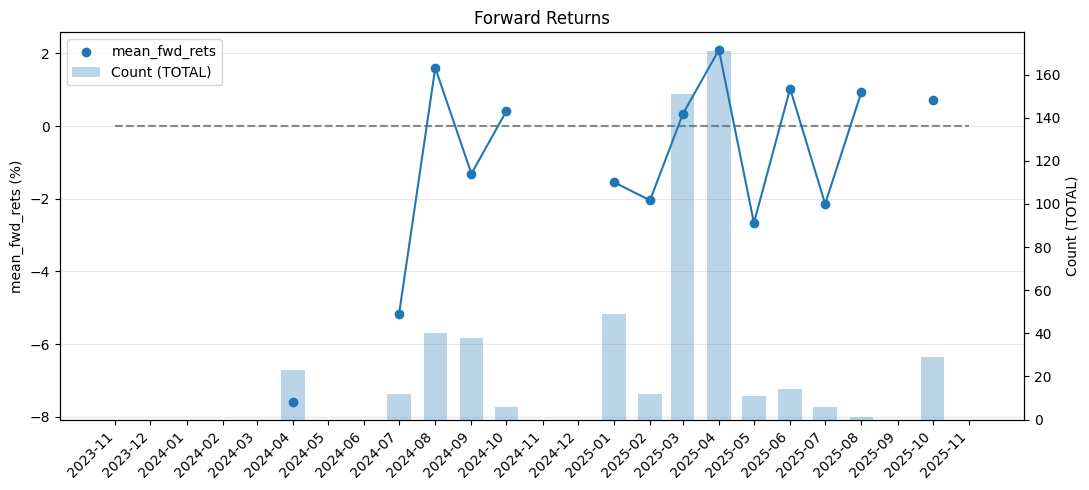

In [1272]:
fig, axes = plot_regime_vol_stat_over_time(
    cross_agg, combo=(-1, 1, 'mean_fwd_rets'), title="Forward Returns", percent_scale=1
)

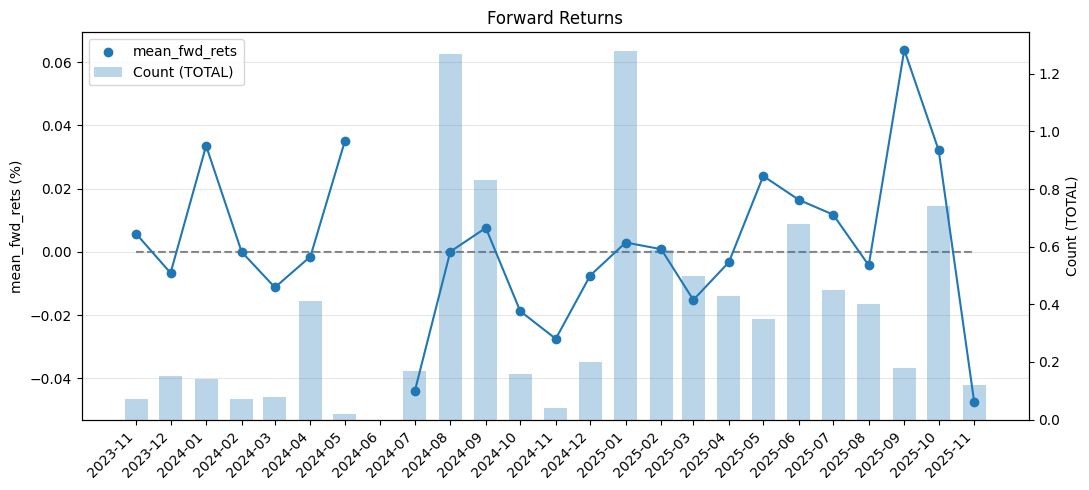

In [896]:
fig, axes = plot_regime_vol_stat_over_time(
    capped_agg, combo=(-1, 0, 'mean_fwd_rets'), title="Forward Returns", percent_scale=1
)

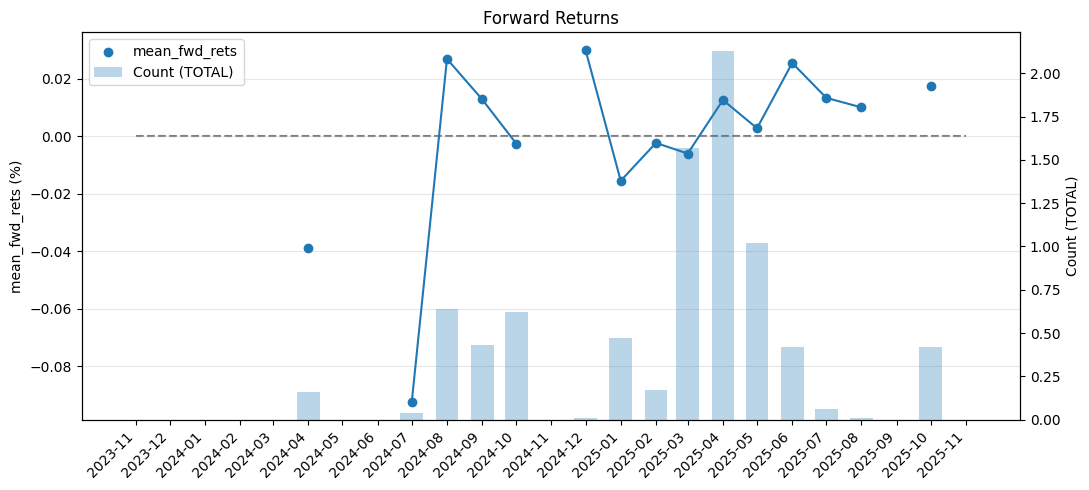

In [897]:
fig, axes = plot_regime_vol_stat_over_time(
    capped_agg, combo=(-1, 1, 'mean_fwd_rets'), title="Forward Returns", percent_scale=1
)

In [1281]:
capped_, cross_ = show_fwd_rets_by_regime_and_vol(H, delta, regime_dfs)

In [1304]:
capped_, cross_ = show_fwd_rets_by_regime(H, delta, regime_dfs)

In [ ]:
capped = pd.concat(capped_)

In [1312]:
capped = capped.reset_index()
capped['fwd_ret_sum'] = capped['count'] * capped['mean_fwd_rets']
capped['fwd_idio_sum'] = capped['count'] * capped['mean_fwd_idio']

In [1323]:
stats = {}
for i in regime_dfs.keys():
    df = regime_dfs[i]
    
    stats[i] = pd.Series({'median_long_r2'  :df['long_r2'].median(),
                          'mean_short_r2' :df['short_r2'].mean(),
                          'std_r2_long'   :df['long_r2'].std(),
                          'std_r2_short': df['short_r2'].std()})

In [1324]:
summary = pd.DataFrame(stats.values(), index=stats.keys())
summary

,median_long_r2,mean_short_r2,std_r2_long,std_r2_short
NVDA,0.393134,0.368865,0.087347,0.117866
AVGO,0.324189,0.336661,0.137000,0.141036
TSM,0.251876,0.220569,0.181010,0.195240
AMD,0.353572,0.361992,0.118394,0.123810
MU,0.282077,0.307449,0.132531,0.136030
QCOM,0.203301,0.236319,0.133921,0.136654
INTC,0.119754,0.139875,0.076865,0.094544
ARM,0.247854,0.250272,0.116592,0.120400
TXN,0.122578,0.141666,0.074328,0.079656
ADI,0.121686,0.131442,0.066870,0.083962


In [ ]:
d = data['stock_rets_min'].corr()[(data['stock_rets_min'].corr() > 0.3) & (data['stock_rets_min'].corr() < 0.4)]
d = d.replace(1.000, np.nan)
d = d.dropna(how='all')
d.T.dropna(how='all', axis=0)

In [7]:
import plotly.graph_objects as go
import plotly.io as pio
from typing import Sequence
from factor_analysis_functions import run_full_pipeline_multifactor_r2

def plot_interactive_r2_dashboard_multifactor(
    *,
    filing_date_gte: str,
    stock: Sequence[str],
    regressor: Sequence[str],
    short_lookback: int = 20,
    long_lookback: int = 60,
    # fetch knobs
    dt_updated: bool = False,
    dt_updated_reg: bool = False,
    minute_waiting_time: int = 60,
    minute_chunksize: int = 200,
    minute_fetch_in_chunks: bool = False,
    daily_start_date: str | None = None,
    daily_end_date: str | None = None,
    minute_start_date: str | None = None,
    minute_end_date: str | None = None,
    # presentation
    init_stock: str | None = None,
    title: str | None = None,
    optimal_beta_kwargs: Dict[str, Any] = None,
):
    # ---------- build data ----------
    pipe = run_full_pipeline_multifactor_r2(
        filing_date_gte=filing_date_gte,
        stock=stock,
        regressor=regressor,
        lookback_short=short_lookback,
        lookback_long=long_lookback,
        dt_updated=dt_updated,
        dt_updated_reg=dt_updated_reg,
        minute_waiting_time=minute_waiting_time,
        minute_chunksize=minute_chunksize,
        minute_fetch_in_chunks=minute_fetch_in_chunks,
        daily_start_date=daily_start_date,
        daily_end_date=daily_end_date,
        minute_start_date=minute_start_date,
        minute_end_date=minute_end_date,
        use_optimal_betas=True,
        optimal_beta_kwargs=optimal_beta_kwargs,
    )

    r2s = pipe["r2_short_daily"]   # index: trading_day, cols: tickers
    r2l = pipe["r2_long_daily"]

    # ensure aligned index across both frames
    idx = r2s.index.union(r2l.index).sort_values()
    r2s = r2s.reindex(idx)
    r2l = r2l.reindex(idx)

    # ---------- figure ----------
    fig = go.Figure()
    tickers = list(r2s.columns)
    init = init_stock or (tickers[0] if tickers else None)
    if init is None:
        return go.Figure()

    # add 2 traces per stock, default hidden; show only init
    for t in tickers:
        fig.add_trace(go.Scatter(
            x=idx, y=r2s[t], mode="lines", name=f"{t} R² (short {short_lookback}d)",
            hovertemplate="%{x|%Y-%m-%d}<br>R²=%{y:.3f}<extra></extra>",
            visible=(t == init)
        ))
        fig.add_trace(go.Scatter(
            x=idx, y=r2l[t], mode="lines", name=f"{t} R² (long {long_lookback}d)",
            line=dict(dash="dash"),  # dashed line for long lookback
            hovertemplate="%{x|%Y-%m-%d}<br>R²=%{y:.3f}<extra></extra>",
            visible=(t == init)
        ))

    # dropdown to toggle stocks: flip visibility for the pair of traces belonging to that ticker
    buttons = []
    total = len(fig.data)
    traces_per_stock = 2
    for i, t in enumerate(tickers):
        vis = [False] * total
        base = i * traces_per_stock
        vis[base] = True
        vis[base + 1] = True
        buttons.append(dict(
            label=t,
            method="update",
            args=[{"visible": vis},
                  {"title": f"{t} — Rolling multi-factor R² (short vs long)"}],
        ))

    fig.update_layout(
        updatemenus=[dict(
            type="dropdown", direction="down", x=1.0, xanchor="right", y=1.12, yanchor="top",
            buttons=buttons, showactive=True, bgcolor="white", bordercolor="#ccc", pad=dict(r=8, t=2, b=2, l=2),
        )],
        xaxis=dict(title="Trading day"),
        yaxis=dict(title="R²", rangemode="tozero"),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="left", x=0),
        template="plotly_white",
        margin=dict(l=70, r=70, t=70, b=60),
        title=title or f"{init} — Rolling multi-factor R² (short vs long)"
    )
    pio.templates.default = "plotly_white"
    return fig


In [1347]:
data['pipe']['best_params']['SLAB']

{'best_method': 'ridge',
 'best_factor': ('SPY', 'SMH'),
 'best_lam': np.float64(0.99),
 'best_ridge': np.float64(0.0001)}

In [8]:
fig = plot_interactive_r2_dashboard_multifactor(
        filing_date_gte="2023-09-01",
        stock=stock,
        regressor=['QQQ', 'SPY', 'SMH'],
        short_lookback=short_lookback,
        long_lookback=long_lookback,
        dt_updated=dt_updated,
        dt_updated_reg=dt_updated_reg,
        minute_waiting_time=minute_waiting_time,
        minute_chunksize=minute_chunksize,
        minute_fetch_in_chunks=minute_fetch_in_chunks,
        optimal_beta_kwargs=optimal_beta_kwargs,
        minute_end_date = '2025-11-04'
    )

[1/37] NVDA: start
last date saved :  2025-11-04 19:55:00-05:00
Minute level data loaded from CSV (earliest): NVDA_5minute_2023-11_minute_level_data.csv
saving because we have the file and we do not want to update date : 2025-11-04 19:55:00-05:00
2025-11-04 19:55:00-05:00 NVDA
[1/37] NVDA: done
[2/37] AVGO: start
last date saved :  2025-11-04 19:55:00-05:00
Minute level data loaded from CSV (earliest): AVGO_5minute_2023-11_minute_level_data.csv
saving because we have the file and we do not want to update date : 2025-11-04 19:55:00-05:00
2025-11-04 19:55:00-05:00 AVGO
[2/37] AVGO: done
[3/37] TSM: start
last date saved :  2025-11-04 19:55:00-05:00
Minute level data loaded from CSV (earliest): TSM_5minute_2023-11_minute_level_data.csv
saving because we have the file and we do not want to update date : 2025-11-04 19:55:00-05:00
2025-11-04 19:55:00-05:00 TSM
[3/37] TSM: done
[4/37] AMD: start
last date saved :  2025-11-04 19:55:00-05:00
Minute level data loaded from CSV (earliest): AMD_5mi

In [9]:
import plotly.io as pio
pio.renderers.default = "browser"
fig.show()  # pops a new browser tab

#### Spell Descriptions

In [ ]:
spell = regime_series.ne(regime_series.shift()).cumsum().groupby(regime_series['idio_regime_d0.3']).value_counts().groupby(level=0).agg(['mean', 'median', 'count', 'min', 'max']).round(2)
spell

##### Transition matrix 

In [ ]:
trans = pd.crosstab(regime_series['idio_regime_d0.3'].shift(10), regime_series['idio_regime_d0.3'], normalize='index')
trans